# OSE-Summer School 2019
## Wk5: Computation, Newton and Quasi Newton Method

In [1]:
import numpy as np
import sympy as sy
import scipy.linalg as la
from matplotlib import pyplot as plt
from scipy import optimize as opt
import time

### Problem 1

In [2]:
f = opt.rosen        # The Rosenbrock function
df = opt.rosen_der   # The first derivative
d2f = opt.rosen_hess # The second derivative (Hessian)

result = opt.fmin_bfgs(f=f, x0=[-2,2], fprime=df, maxiter=1000, retall=True)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


In [3]:
def newton_method(Df, D2f, x0, maxiter=100, tol=1e-10, disp=False):
    
    it = 0
    x = x0
    Dfx_norm = la.norm(Df(x))
    
    while (Dfx_norm > tol) and (it < maxiter):
        
        it += 1
        z = la.solve(D2f(x), Df(x).T)
        xnew = x - z
        Dfx_norm = la.norm(Df(xnew))
        x = xnew
    
    if disp == True:
        print("Iteration: %d,  |Dfx| = %6.6f" % (it, Dfx_norm))
    
    return (x, it)

In [4]:
x, it = newton_method(Df=df, D2f=d2f, x0=[-2,2], maxiter=50, tol=1e-10)
x

array([1., 1.])

### Problem 2

In [5]:
def BFGS(Df, x0, maxiter=100, tol=1e-10, disp=True):
    
    it = 0
    x = x0
    Dfx = Df(x)
    Dfx_norm = la.norm(Dfx)
    Ainv = np.eye(len(x))
    end = False
    
    while (Dfx_norm > tol) and (it < maxiter) and (end==False):
        
        it += 1
        s = - Ainv @ Dfx.T
        xnew = x + s
        Dfxnew = Df(xnew)
        Dfx_norm = la.norm(Dfxnew)
        
        y = Dfxnew.T - Dfx.T
        sy = s.T @ y
        ys = np.outer(y, s.T)
        if (sy)**2 == 0:
            print("The iteration terminates early because (s'y)^2 = 0")
            end = True
        else:
            Ainv = Ainv + ((sy + y.T@Ainv@y) / ((sy)**2)) * np.outer(s,s.T) - \
                    (Ainv@ys + ys.T@Ainv) / (sy)
        
        x = xnew
        Dfx = Dfxnew
    
    if disp == True:
        print("Iteration: %d,  |Dfx| = %6.6f" % (it, Dfx_norm))
    
    return (x, it)

In [6]:
x, it = BFGS(Df=df, x0=[-2,2], maxiter=1000, tol=1e-10)
x

Iteration: 153,  |Dfx| = 0.000000


array([1., 1.])

### Problem 3

In [7]:
def compare(N: int, maxiter=1000, tol=1e-10):
    
    X = np.zeros((N,3))
    Iter = np.zeros((N,3))
    Time = np.zeros((N,3)) 
    
    for i in range(N):
        
        x0 = np.random.uniform(-3,3,2)  # draw two random number from Uniform[-3,3]
        
        # Newton Method
        start = time.time()        
        Iter[i,0] = newton_method(df, d2f, x0, maxiter=maxiter, tol=tol, disp=False)[1]
        Time[i,0] = time.time() - start
        
        # My BFGS
        start = time.time()
        Iter[i,1] = BFGS(df, x0, maxiter=maxiter, tol=tol, disp=False)[1]
        Time[i,1] = time.time() - start
        
        # SciPy's BFGS
        start = time.time()
        result = opt.fmin_bfgs(f=f, x0=[-2,2], fprime=df, 
                               maxiter=maxiter, gtol=tol, disp=False, retall=True)
        Time[i,2] = time.time() - start
        Iter[i,2] = len(result[1]) - 1
        
    # plot
    fig = plt.subplots(1,1,figsize=[8,5])
    plt.subplot(111)
    plt.scatter(Time[:,0], Iter[:,0], label='Newton Method', alpha=.6, s=50)
    plt.scatter(Time[:,1], Iter[:,1], label='BFGS', alpha=.6, s=50)
    plt.scatter(Time[:,2], Iter[:,2], label='scipy.optimize.fmin_bfgs()', alpha=.6, s=50)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Time(seconds)")
    plt.ylabel("Iterations")
    plt.legend()
        
    return (Iter, Time)   

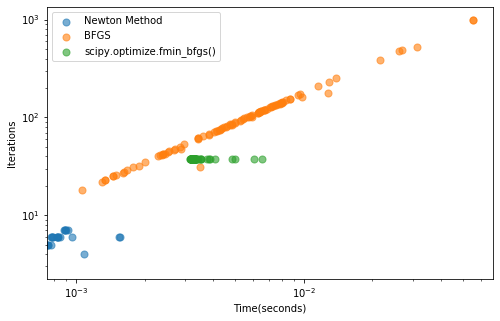

In [18]:
Iter, Time = compare(100)

### Problem 4

In [19]:
def gauss_newton(jac, residual, x0, maxiter=100, tol=1e-5):
    
    it = 0
    x = x0
    rx = residual(x)
    Jx = jac(x)
    Dfx = Jx.T@rx
    converge = False
    
    while (la.norm(Dfx) > tol) and (it < maxiter):
        
        it += 1
        z = la.solve(Jx.T@Jx, Jx.T)
        xnew = x - z@rx
        rx = residual(xnew)
        Jx = jac(xnew)
        Dfx = Jx.T@rx
        x = xnew
        
    if la.norm(Dfx) <= tol:
        converge = True
    
    return (x, converge, it)

In [20]:
# Generate random data
T = np.arange(10)
y = 3*np.sin(0.5*T) + 0.5*np.random.randn(10) # perturbed data

# Define the model function and the residual (based on the data)
model = lambda x, t : x[0]*np.sin(x[1]*t)
residual = lambda x : model(x, T) - y

# Define the Jacobian of the residual function,computed by hand
jac = lambda x : np.column_stack((np.sin(x[1]*T), x[0]*T*np.cos(x[1]*T)))

# find x
x0 = np.array([2.5, 0.6])  # initial guess
x, covn, niters = gauss_newton(jac, residual, x0, maxiter=100, tol=1e-3)
print("x =", np.round(x,4), ", conversion =", covn, ", Iteration =", niters)

x = [2.9705 0.5137] , conversion = True , Iteration = 5


In [21]:
# compare it to scipy.optimize.leastsq()
minx = opt.leastsq(func=residual, x0=np.array([2.5, 0.6]), Dfun=jac)[0]
minx - x

array([0., 0.])

### Problem 5

In [22]:
# data
data = np.load('population.npy')
T = data[:,0]
y = data[:,1]

# Define the exponential model function and the residual
exp_model = lambda x, t : x[0]*np.exp(x[1]*(t+x[2]))
exp_residual = lambda x : exp_model(x, T) - y

# Define the logistic model function and the residual
log_model = lambda x, t : x[0] / (1+np.exp(-x[1]*(t+x[2])))
log_residual = lambda x : log_model(x, T) - y

# Define the Jacobian of the residual function,computed by hand
exp_jac = lambda x : np.column_stack(((np.exp(x[1]*(T+x[2])),
                                     x[0]*(T+x[2])*np.exp(x[1]*(T+x[2])),
                                     x[0]*x[1]*np.exp(x[1]*(T+x[2])))))
log_jac = lambda x : np.column_stack(((1/(1+np.exp(-x[1]*(T+x[2]))), 
                                    (x[0]*(T+x[2])*np.exp(-x[1]*(T+x[2]))) / ((1+np.exp(-x[1]*(T+x[2])))**2),
                                    (x[0]*x[1]*np.exp(-x[1]*(T+x[2]))) / ((1+np.exp(-x[1]*(T+x[2])))**2))))

# find x using the exponential model
exp_x0 = np.array([1.5, 0.4, 2.5])  # initial guess
exp_x = opt.leastsq(func=exp_residual, x0=exp_x0, Dfun=exp_jac)[0]
                 
# find x using the logistic model
log_x0 = np.array([150, 0.4, -15])  # initial guess
log_x = opt.leastsq(func=log_residual, x0=log_x0, Dfun=log_jac)[0]

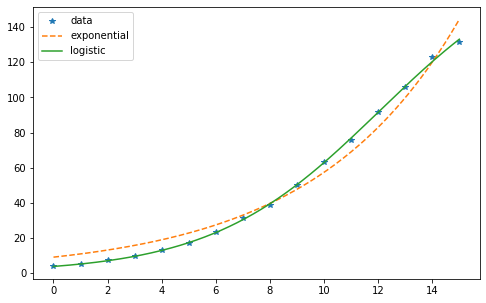

In [23]:
# Plot the fitted model with the observed data and the data-generating curve.
dom = np.linspace(T[0], T[-1], 200)

fig = plt.subplots(1,1,figsize=[8,5])
plt.subplot(111)
plt.plot(T, y, '*', label='data')                                # Observed data.
plt.plot(dom, exp_model(exp_x, dom), '--', label='exponential')  # Fitted using the exponential model
plt.plot(dom, log_model(log_x, dom), label='logistic')           # Fitted using the logistic model
plt.legend()
plt.show()

### End